<a href="https://colab.research.google.com/github/Chaitanya007-Con/Experiments/blob/main/Classification_rnn_char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
%matplotlib inline

# Preparing the Data

In [82]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt']
Slusarski


In [83]:
print(category_lines['German'][:10])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer']


In [84]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Here we will convert names to tensors

In [85]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [86]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [87]:
input = lineToTensor('Amy')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0086, -2.9098, -2.8617, -3.0017, -2.8771, -2.9639, -2.8720, -2.8697,
         -2.8828, -2.8102, -2.8776, -2.8999, -2.8037, -2.8443, -2.9327, -2.9230,
         -2.8919, -2.8246]], grad_fn=<LogSoftmaxBackward>)


# Training the data

Preparing for training with some helper functions

In [88]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 12)


In [89]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Yankilovich
category = Irish / line = Roach
category = Dutch / line = Asch
category = Spanish / line = Acosta
category = French / line = Brisbois
category = Russian / line = Bachmanov
category = Vietnamese / line = Bach
category = Dutch / line = Nifterik
category = Chinese / line = Cao
category = French / line = Lavigne


# Training the N/w

In [90]:
criterion = nn.NLLLoss()

In [91]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [92]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.5913 Maclean / Greek ✗ (Scottish)
10000 10% (0m 15s) 2.0700 Thean / Arabic ✗ (Chinese)
15000 15% (0m 23s) 1.9678 Torres / Portuguese ✗ (Spanish)
20000 20% (0m 30s) 0.9829 Oh  / Korean ✓
25000 25% (0m 38s) 3.7574 Munro / Portuguese ✗ (Scottish)
30000 30% (0m 46s) 1.9058 Suero / Portuguese ✗ (Spanish)
35000 35% (0m 54s) 0.7829 Suk / Korean ✓
40000 40% (1m 1s) 1.4865 Koury / Arabic ✓
45000 45% (1m 9s) 0.9240 Makioka / Japanese ✓
50000 50% (1m 17s) 1.2031 Sierra / Portuguese ✗ (Spanish)
55000 55% (1m 25s) 0.2161 O'Halloran / Irish ✓
60000 60% (1m 33s) 0.4819 Shin / Korean ✓
65000 65% (1m 42s) 0.5079 Hlopov / Russian ✓
70000 70% (1m 50s) 0.5376 Yakubovich / Russian ✓
75000 75% (1m 58s) 2.2564 Speziale / French ✗ (Italian)
80000 80% (2m 6s) 2.0402 Kucera / Spanish ✗ (Czech)
85000 85% (2m 14s) 0.2057 Sniegowski / Polish ✓
90000 90% (2m 23s) 0.1249 O'Brian / Irish ✓
95000 95% (2m 31s) 0.8607 Sebastino / Italian ✓
100000 100% (2m 39s) 2.2919 Quiros / Portuguese ✗ (Spanish)


# Visualizing the results

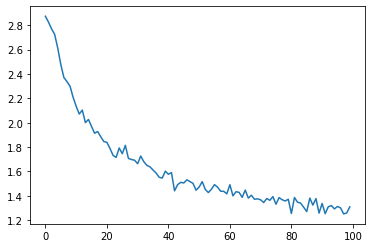

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluate the results

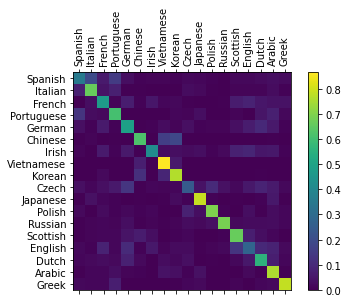

In [61]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Let's test out a user input

In [102]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('James')
predict('Maxim')


> James
(-1.85) English
(-1.92) Greek
(-1.99) Czech

> Maxim
(-1.24) Arabic
(-1.98) French
(-2.17) Irish
